In [1]:
import time
import threading
import logging
#import retro
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from sklearn.preprocessing import scale
import numpy as np
import cv2
import numpy as np
#import keyboard
import gym
import matplotlib.pylab as plt
from IPython.display import clear_output
#retro.data.list_games()

In [2]:
#obs, rew, done, info = env.step(env.action_space.sample())
#(224, 240, 3)
#MultiBinary(9)                          
class RAM_ANN():
  def __init__(self, action_space, state_space, frameskip, seed):
    self.seed = seed
    initializer1 = initializers.GlorotUniform (seed = self.seed+1)
    initializer2 = initializers.GlorotUniform (seed = self.seed+2)
    initializer3 = initializers.GlorotUniform (seed = self.seed+3)
    initializer4 = initializers.GlorotUniform (seed = self.seed+4)
    self.frameskip = frameskip
    self.action_space = len(action_space)
    num_actions = self.action_space
    #NN layers
    ram_input = layers.Input(shape=(state_space))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    
    layer5 = layers.Dense(128, activation="relu", kernel_initializer = initializer1)(ram_input)
    layer6 = layers.Dense(512, activation="relu", kernel_initializer = initializer2)(layer5)
    layer7 = layers.Dense(128, activation="relu", kernel_initializer = initializer3)(layer6)
    action = layers.Dense(num_actions, activation="linear", kernel_initializer = initializer4)(layer7)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=ram_input, outputs=action)
    self.loss_fn = tf.keras.losses.Huber()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.0000625*16, clipnorm=1.0)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

class A3C():
  def __init__(self, action_space, state_space, frameskip, seed):
    self.seed = seed
    initializer1 = initializers.GlorotUniform (seed = self.seed+1)
    initializer2 = initializers.GlorotUniform (seed = self.seed+2)
    initializer3 = initializers.GlorotUniform (seed = self.seed+3)
    initializer4 = initializers.GlorotUniform (seed = self.seed+4)
    self.frameskip = frameskip
    self.action_space = len(action_space)
    self.num_actions = self.action_space
    self.state_space = state_space
    #NN layers
    ram_input = layers.Input(shape=(self.state_space))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer5 = layers.Dense(256, activation="relu", kernel_initializer = initializer1)(ram_input)
    logaction = layers.Dense(self.num_actions, activation="linear", kernel_initializer = initializer2)(layer5)
    value = layers.Dense(1, activation="linear", kernel_initializer = initializer3)(layer5)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=ram_input, outputs=[logaction, value])
    self.loss_fn = tf.keras.losses.MeanSquaredError()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)


class CONV_ANN():
  def __init__(self, action_space, ndim):
    self.action_space = len(action_space)
    num_actions = self.action_space
    #NN layers
    image_input = layers.Input(shape=(ndim,ndim,4))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(image_input)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)

    action = layers.Dense(num_actions, activation="linear")(layer5)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=image_input, outputs=action)
    self.loss_fn = tf.keras.losses.Huber()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.001, epsilon=0.00015)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

class LookAhead():
  def __init__(self, action_space):
    self.action_space = len(action_space)
    image_input = layers.Input(shape=(84,84,4))
    action_input = layers.Input(shape=self.action_space)
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(image_input)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Concatenate(axis=1)([layer4, action_input])
    layer6 = layers.Dense(512, activation="relu")(layer5)
    layer7 = layers.Dense(3136, activation="relu")(layer6)
    layer8 = layers.Reshape((7, 7, 64))(layer7)
    layer9 = layers.Conv2DTranspose(64,3)(layer8)
    layer10 = layers.Conv2DTranspose(32,12)(layer9)
    layer11 = layers.Conv2DTranspose(4,65)(layer10)
    value_output = layers.Dense(1, activation='linear')(layer5)

    #Define NN parameters.
    toymodel = keras.Model(inputs=[image_input, action_input], outputs=[layer11, value_output])
    loss_fn = tf.keras.losses.Huber()
    optimizer = keras.optimizers.Adam(learning_rate=0.00025)
    toymodel.compile(optimizer, loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

In [3]:
#@title
class Agent():
    def __init__(self,runname, action_space, num_of_threads = 1, rom_name = 'BreakoutNoFrameskip-v4'):
        self.rom_name = rom_name
        self.eval_env = gym.make(self.rom_name)
        self.action_space = action_space
        self.num_of_threads = int(num_of_threads)
        
        self.lives = 5     #5 for Breakout, 3 for Space Invaders
        # Every number of steps equal to the epoch length, evalulation a greedy run of the Q function.
        self.eval_epsilon = 0.05
        self.eval_reps = 10
        self.epoch_len = 50000
        
        self.steps_taken = 0 
        self.runname = runname
        self.len_of_episode = 10000

        #Set hyperparameters.
        self.epsilon = 1.0
        self.epsilon_max = 1.0
        self.epsilon_min = 0
        self.epsilon_lag = 50000
        self.annealing_time = 1000000
        self.gamma = 0.99
        self.max_memory_len = 1000000
        self.batch_size = 32
        self.steps_per_update = 4
        self.reward_scaler = 0.01
        self.target_update = 10000
        self.window = 25
        self.frameskip = 4 

        
        #Initialize containers which will be prepared in thread_prep()
        self.loss_history = []
        self.action_history = []
        self.state_history= []
        self.next_state_history = []
        self.reward_history = []
        self.done_history = []
        self.episodic_return = []
        self.return_history = [] 
        self.env_container = []
        self.threads = []
        self.epsilon_schedule = []
        self.grads = []
        self.evaluations = []
        self.thread_lives = []
        self.restart = []
        self.thread_prep()
        
        #Initialize target and behavior network.
        self.seed = 42
        self.behavior = CONV_ANN(self.action_space, 84) #RAM_ANN(self.action_space, 128, self.frameskip, self.seed)
        self.target = CONV_ANN(self.action_space, 84) #RAM_ANN(self.action_space, 128, self.frameskip,self.seed)
        self.A3C = A3C(self.action_space, 128, self.frameskip, self.seed)

    def clip_reward(self, reward):
        if reward > 0:
            return 1
        elif reward == 0:
            return 0
        else:
            return -1
    
    def popback(self, state_block, incoming_state):
        state_block.pop(0)
        state_block.append(incoming_state)
        return state_block

    def gradient_update(self, 
                        runname,
                        state_history, 
                        next_state_history,
                        rewards_history,
                        action_history,
                        loss_history,
                        model,
                        target_model,
                        gamma,
                        batch_size,
                        done_history,
                        action_space):
    
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            next_state_sample = np.array([next_state_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])
            future_rewards = target_model.toymodel.predict(next_state_sample)
            updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)
            updated_q_values = updated_q_values *(1-done_sample) - done_sample
            masks = tf.one_hot(action_sample, len(action_space))
            with tf.GradientTape() as tape:  
                q_values = model.toymodel(state_sample)
                q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = model.loss_fn(updated_q_values, q_actions)
            loss_history = loss_history.append(loss)
            grads = tape.gradient(loss, model.toymodel.trainable_variables)
            model.toymodel.optimizer.apply_gradients(zip(grads, model.toymodel.trainable_variables))

    def gradient_update_threads(self,):    
            # Get indices of samples for replay buffers
            indices = np.arange(len(self.state_history))
            # Using list comprehension to sample from replay buffer
            rewards_sample = [self.reward_history[i] for i in indices]
            action_sample = [self.action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(self.done_history[i]) for i in indices])
            future_rewards = self.target.toymodel.predict(self.next_state_history)
            updated_q_values = rewards_sample + self.gamma * tf.reduce_max(future_rewards, axis=1)
            updated_q_values = updated_q_values *(1-done_sample) - done_sample
            masks = tf.one_hot(action_sample, len(self.action_space))
            with tf.GradientTape() as tape:  
                q_values = self.behavior.toymodel(self.state_history)
                q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = self.behavior.loss_fn(updated_q_values, q_actions)
            loss_history = self.loss_history.append(loss.numpy())
            grads = tape.gradient(loss, self.behavior.toymodel.trainable_variables)
            self.behavior.optimizer.apply_gradients(zip(grads, self.behavior.toymodel.trainable_variables))

    def calculate_grad(self,):    
            # Get indices of samples for replay buffers
            indices = np.arange(len(self.state_history))
            # Using list comprehension to sample from replay buffer
            rewards_sample = [self.reward_history[i] for i in indices]
            action_sample = [self.action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(self.done_history[i]) for i in indices])
            future_rewards = self.target.toymodel.predict(self.next_state_history)
            updated_q_values = rewards_sample + self.gamma * tf.reduce_max(future_rewards, axis=1)
            updated_q_values = updated_q_values *(1-done_sample) - done_sample
            masks = tf.one_hot(action_sample, len(self.action_space))
            with tf.GradientTape() as tape:  
                q_values = self.behavior.toymodel(self.state_history)
                q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = self.behavior.loss_fn(updated_q_values, q_actions)
            loss_history = self.loss_history.append(loss.numpy())
            grads = tape.gradient(loss, self.behavior.toymodel.trainable_variables)
            return grads
            
    def save_history(self,):   
        runname = self.runname
        #np.save(runname + 'action_history',self.action_history)
        #np.save(runname + 'state_history', self.state_history)
        #np.save(runname + 'next_state_history', self.next_state_history)
        #np.save(runname + 'reward_history', self.reward_history)
        #np.save(runname + 'done_history', self.done_history)
        #np.save(runname + 'return_history', self.episodic_return)
        #np.save(runname + 'evaluations', self.evaluations)
        #np.save(runname + 'loss_history', self.loss_history)
        self.behavior.toymodel.save(runname+'_behavior')
        self.target.toymodel.save(runname+'_target')

    def RGB_preprocess(self, action, env, frameskips):
        state_output = []
        reward = 0
        done = []
        for i in range(frameskips):
            s, r, d, info = env.step(action)
            done.append(d)
            reward += r
            s = cv2.cvtColor(s, cv2.COLOR_RGB2GRAY)
            s = cv2.resize(s, (84, 84), interpolation=cv2.INTER_AREA)
            state_output.append(s/255.0)
        #return np.max(np.dstack(state_output), axis=2), reward, d, info #For max stacking
        return np.dstack(state_output).astype('float16'), reward, True in done, info #For frame stacking

    def preprocess(self, state):
        #return [state[0]/4.8, state[1], state[2]/0.418, state[3]]
        return state/255.0

    def memory_manager(self,array, mem_size):
        num_delete = len(array) - mem_size
        if num_delete < 0:
            None
        else:
            del array[:num_delete]
            
    def piecewise_epsilon(self, steps_taken, lag, annealingtime, ep_min, ep_max): #returns epsilon
        anneal_slope= (ep_min-ep_max)/(lag+annealingtime-lag)
        if steps_taken < lag: return ep_max
        if (steps_taken >= lag) and (steps_taken < (lag+annealingtime)): return anneal_slope*steps_taken+(ep_max-anneal_slope*lag)
        else: return ep_min

    def sliding_average(self, array, n):
        output = []
        for i in range(len(array)):
            try:
                output.append(np.average(array[i:i+n]))
            except IndexError:
                break
        return output
    
    def thread_prep(self):
        self.action_history = [[] for i in range(self.num_of_threads)]
        self.state_history = [[] for i in range(self.num_of_threads)]
        self.next_state_history = [[] for i in range(self.num_of_threads)]
        self.reward_history = [[] for i in range(self.num_of_threads)]
        self.done_history = [[] for i in range(self.num_of_threads)]
        self.episodic_return = [[] for i in range(self.num_of_threads)]
        self.env_container = [gym.make(self.rom_name) for i in range(self.num_of_threads)]
        self.steps_taken = [0 for i in range(self.num_of_threads)]
        self.epi_return_holder = [0 for i in range(self.num_of_threads)]
        self.restart = [1 for i in range(self.num_of_threads)]
        self.holding = [True for i in range(self.num_of_threads)]
        self.epsilon_schedule = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
        self.thread_lives = [self.lives for i in range(self.num_of_threads)]
        self.current_state_storage = [[] for i in range(self.num_of_threads)]
    
    def reset_history(self):
        self.action_history = [[] for i in range(self.num_of_threads)]
        self.state_history = [[] for i in range(self.num_of_threads)]
        self.next_state_history = [[] for i in range(self.num_of_threads)]
        self.reward_history = [[] for i in range(self.num_of_threads)]
        self.done_history = [[] for i in range(self.num_of_threads)]        
        
    def agent_thread(self, thread_num):
        #logging.info("Thread %s: starting", thread_num)
        #self.env_container[thread_num].seed(seed)
        self.Q_step(self.env_container[thread_num], thread_num)
        #logging.info("Thread %s: finishing", thread_num)
    
    def condense_history(self,):
        self.action_history = np.array(self.action_history).flatten()
        self.state_history = np.vstack(self.state_history)
        self.next_state_history = np.vstack(self.next_state_history)
        self.done_history = np.array(self.done_history).flatten()
        self.reward_history = np.array(self.reward_history).flatten()
        
    def start_threads(self,num_of_training_steps):
        for i in range(num_of_training_steps):
            if i%10==0: print ('Running step ', i, ' of ', num_of_training_steps)
            #format = "%(asctime)s: %(message)s"
            #logging.basicConfig(format=format, level=logging.INFO, datefmt="%H:%M:%S")
            for i in range(self.num_of_threads):
                #logging.info("Main    : create and start thread %d.", i)
                x = threading.Thread(target=self.agent_thread, args=(i,))
                self.threads.append(x)
                x.start()                                   
            for j in self.threads:
                j.join()
            self.condense_history()
            self.gradient_update_threads()
            if (self.steps_taken[0])%self.target_update==0: 
                print ('Collective steps observed: ' + str(np.sum(self.steps_taken)))
                self.target.toymodel.set_weights(self.behavior.toymodel.get_weights())
                print ('Target network updated.')
                self.save_history()
                
            self.reset_history()
        self.evaluate_NN(self.eval_env, 0.05, 10)
        self.plot_data()

    def Q_step(self, env, thread_num, epsilon=0):    #Double Deep Q
        #env.seed(thread_num)
        epsilon = self.piecewise_epsilon(self.steps_taken[thread_num], self.epsilon_lag, self.annealing_time, self.epsilon_schedule[thread_num], self.epsilon_max)           
        #Restart the environment if lives are out.
        if self.restart[thread_num] ==1:    
            env.seed(self.seed)
            #if len(self.episodic_return[thread_num])%25==0: self.plot_data()
            self.thread_lives[thread_num] = self.lives
            env.reset()
            s, reward, done, info = self.RGB_preprocess(1, env, self.frameskip)
            self.restart[thread_num] = 0
            #Enter the loop.
        #Trigger the next life if lives are left.
        elif self.restart[thread_num] == 2:
            s, reward, done, info = self.RGB_preprocess(1, env, self.frameskip)
            self.restart[thread_num] = 0
        #Else, make the next state from the previous step the current state, s.
        else:
            s = self.current_state_storage[thread_num]
        
        for step in range(self.steps_per_update):
            #Choose an action from according to epsilson-greedy policy.  
            if np.random.random() < epsilon:
                a = np.random.choice(np.arange(len(self.action_space)))
            else: 
                a_probs = self.behavior.toymodel(np.expand_dims(s,0), training=False)
                a = tf.argmax(a_probs[0]).numpy()
            s_prime, reward, done, info = self.RGB_preprocess(self.action_space[a], env, self.frameskip)
            self.epi_return_holder[thread_num] += reward

            #Save to history
            self.reward_history[thread_num].append(self.clip_reward(reward)*self.reward_scaler)
            self.state_history[thread_num].append(s)
            self.action_history[thread_num].append(a)
            self.next_state_history[thread_num].append(s_prime)
            self.done_history[thread_num].append(done)
            
            #Restart when the end of the episode is reached.  
            if done:                                                                              #FUNCTIONIZE!
                #Set the last frame to -1 to discourage dying.  
                self.done_history[thread_num][-1] = True
                self.restart[thread_num] = 1
                self.episodic_return[thread_num].append(self.epi_return_holder[thread_num])
                self.epi_return_holder[thread_num] = 0 

            if not (int(info['ale.lives']) == self.thread_lives[thread_num]):                                         
                self.done_history[thread_num][-1] = True
                self.thread_lives[thread_num] = int(info['ale.lives'])
                self.restart[thread_num] = 2 #Needs firing start.    
                self.episodic_return[thread_num].append(self.epi_return_holder[thread_num])
                self.epi_return_holder[thread_num] = 0 
                #break      #Enable break if you only want to learn from the first life.                            

            s = s_prime

            self.steps_taken[thread_num] += 1
        self.current_state_storage[thread_num] = s
            
        
    def plot_data(self,):
        clear_output()
        plt.figure(figsize=(10,2))
        for i in range(self.num_of_threads):
            plt.plot(self.episodic_return[i], label='Thread ' + str(i))
        plt.xlabel('Episode')
        plt.ylabel('Return')
        plt.legend(loc=7)
        plt.show()
        
        plt.figure(figsize=(10,2))
        for i in range(self.num_of_threads):
            plt.plot(self.sliding_average(self.episodic_return[i], self.window), label='Thread '+str(i))
        plt.xlabel('Episode')
        plt.ylabel(str(self.window)+'-averaged Return')
        plt.legend(loc=7)
        plt.show()

        plt.figure(figsize=(10,2))
        plt.plot(self.evaluations)
        plt.xlabel('Episode')
        plt.ylabel('Evaluation Return')
        plt.show()
        
        plt.figure(figsize=(10,2))
        plt.plot(self.loss_history)
        plt.xlabel('Training Step')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.show()

        plt.figure(figsize=(10,2))
        for i in range(self.num_of_threads):
            Y = [self.piecewise_epsilon(j, self.epsilon_lag, self.annealing_time, self.epsilon_schedule[i], self.epsilon_max) for j in np.arange(self.steps_taken[i])]
            plt.plot(Y, label='Thread '+str(i))
        plt.xlabel('Steps taken')
        plt.ylabel('Epsilon')
        plt.legend(loc=7)
        plt.show()
        
    def evaluate_NN(self, env, epsilon, replicates):
        av_returns = []
        for i in range(replicates):
            s = env.reset()
            s, episode_return, done, info = self.RGB_preprocess(1, env, self.frameskip)
            episode_return = 0
            done = False
            eval_life = self.lives
            while True:
                #Choose epsilon greedy action.
                if np.random.random() < epsilon:
                    a = np.random.choice(np.arange(len(self.action_space)))
                else: 
                    a_probs = self.behavior.toymodel(np.expand_dims(s,0), training=False)
                    a = tf.argmax(a_probs[0]).numpy()
                #Collect information on next state.
                s, reward, done, info = self.RGB_preprocess(self.action_space[a], env, self.frameskip)
                episode_return += reward
                #If a life was lost, don't end the episode. Use fire button to go to next life.
                if not (int(info['ale.lives']) == eval_life):                                         
                    eval_life = int(info['ale.lives'])
                    s, reward, done, info = self.RGB_preprocess(1, env, self.frameskip)
                    av_returns.append(episode_return)  
                    episode_return = 0 
                if done:
                    av_returns.append(episode_return)   
                    break   
        self.evaluations.append(np.average(av_returns))
                             
    def A3C_episode(self, num_training_steps, env, thread_num):    #Double Deep Q
        #np.random.seed(self.seed)
        while self.steps_taken[thread_num] < num_training_steps:
            env.seed(self.seed)
            epi_return = 0 
            steps = 0
            lives = 5     #5 for Breakout, 3 for Space Invaders
            s = self.preprocess(env.reset())
            s, reward, done, info = env.step(1)
            done = False
            #Enter the loop.
            if len(self.episodic_return[thread_num])%25==0: self.plot_data()
            while self.steps_taken[thread_num] < num_training_steps:

                #Break the loop if the maximum number of training examples have been reached.
                if self.steps_taken[thread_num] >= num_training_steps:
                    break
                #Choose an action from according to epsilson-greedy policy.  
                a_probs, value = self.A3C.toymodel(np.expand_dims(s,0), training=False)
                a = np.random.choice(self.action_space,p=tf.nn.softmax(a_probs[0]).numpy())
                
                s_prime, reward, done, info = env.step(self.action_space[a])
                s_prime = self.preprocess(s_prime)
                epi_return += reward

                #Restart when the end of the episode is reached.  
                if done:                                                                              #FUNCTIONIZE!
                    #Set the last frame to -1 to discourage dying.                                             
                    self.done_history[thread_num][-1] = True 
                    self.reward_history[thread_num][-1] = -1
                    self.episodic_return[thread_num].append(epi_return)
                    break
                if not (int(info['ale.lives']) == lives):                                         
                    self.done_history[thread_num][-1] = True 
                    self.reward_history[thread_num][-1] = -1
                    self.episodic_return[thread_num].append(epi_return)
                    lives = int(info['ale.lives'])
                    #print ('Episode finished in ', step_in_episode, 'steps.')
                    break               
                                
                #Monitor the the number of lives from the environemtnt. If the number of lives is reduced, then the player has died. Reset the level.  FUNCTIONIZE!                

                #Save to history
                self.reward_history[thread_num].append(reward*self.reward_scaler)
                self.state_history[thread_num].append(s)
                self.action_history[thread_num].append(a)
                self.next_state_history[thread_num].append(s_prime)
                self.done_history[thread_num].append(done)
                 
                if self.steps_taken[thread_num]>self.batch_size and self.steps_taken[thread_num]%self.steps_per_update==0:
                    #Enable option for experience replay by random sampling or total memory sampling.
                    # Get indices of samples for replay buffers
                    indices = np.random.choice(range(len(self.done_history[thread_num])), size=self.batch_size)
                    # Using list comprehension to sample from replay buffer
                    state_sample = np.array([self.state_history[thread_num][i] for i in indices])
                    next_state_sample = np.array([self.next_state_history[thread_num][i] for i in indices])
                    rewards_sample = [self.reward_history[thread_num][i] for i in indices]
                    action_sample = [self.action_history[thread_num][i] for i in indices]
                    done_sample = tf.convert_to_tensor([float(self.done_history[thread_num][i]) for i in indices])
                                        
                    with tf.GradientTape() as tape:
                        future_rewards = self.A3C.toymodel(next_state_sample)[1][:,0]
                        future_rewards = future_rewards *(1-done_sample) - done_sample                    
                        discounted_reward = rewards_sample + self.gamma * future_rewards   
                        logits, values = self.A3C.toymodel(state_sample)   
                        values = values[:,0]
                        advantage = discounted_reward-values
                        masks = tf.one_hot(action_sample, len(self.action_space))
                        policy = tf.nn.softmax(logits)
                        entropy = tf.reduce_sum(policy * tf.math.log(policy+1e-20),axis=1)
                        value_loss = advantage**2
                        policy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=masks, logits=logits)
                        policy_loss *= tf.stop_gradient(advantage)
                        policy_loss -= 0.0005 * entropy
                        total_loss = (0.5 * value_loss + policy_loss)
                    loss_history = self.loss_history[thread_num].append(np.mean(total_loss))
                    # Calculate local gradients
                    grads = tape.gradient(total_loss, self.A3C.toymodel.trainable_weights)
                    # Push local gradients to global model
                    self.A3C.toymodel.optimizer.apply_gradients(zip(grads, self.A3C.toymodel.trainable_weights))
                    steps += 1                 
                s = s_prime

                self.steps_taken[thread_num] += 1
                self.memory_manager(self.action_history[thread_num], self.max_memory_len)
                self.memory_manager(self.state_history[thread_num], self.max_memory_len)
                self.memory_manager(self.next_state_history[thread_num], self.max_memory_len)
                self.memory_manager(self.reward_history[thread_num], self.max_memory_len)
                self.memory_manager(self.done_history[thread_num], self.max_memory_len)          
        env.close()


        #self.behavior.toymodel.save('120228_Breakout')

In [6]:
atari_action_space = [0,2,3]
env = gym.make("BreakoutNoFrameskip-v4")
#agent = Agent('210405_1', atari_action_space, num_of_threads = 16, rom_name="BreakoutNoFrameskip-v4")
agent.epsilon = 1.0
agent.epsilon_max = 1.0
agent.epsilon_min = 0.1
agent.epsilon_lag = 1
agent.annealing_time = 10000
agent.len_of_episode = 10000
agent.gamma = 0.99
agent.max_memory_len = 100000
agent.batch_size = 32
agent.steps_per_update = 1
agent.reward_scaler = 1
agent.target_update = 50000
#agent.epsilon_schedule = [0.01, 0.01, 0.01, 0.01,
#                          0.05, 0.05, 0.05, 0.05,
#                          0.10, 0.10, 0.10, 0.10,
#                         0.15, 0.15, 0.15, 0.15]

agent.epsilon_schedule = [0.10, 0.10, 0.10, 0.10,
                          0.5, 0.5, 0.5, 0.01,
                          0.01, 0.01, 0.5, 0.01,
                          0.10, 0.10, 0.10, 0.10]

agent.frameskip = 4

#Evaluation parms
agent.eval_epsilon = 0.05
agent.eval_reps = 10
agent.epoch_len = 5000
#agent.episode(10000000, env1)
#LR is 0.001
agent.behavior.toymodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1606144   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

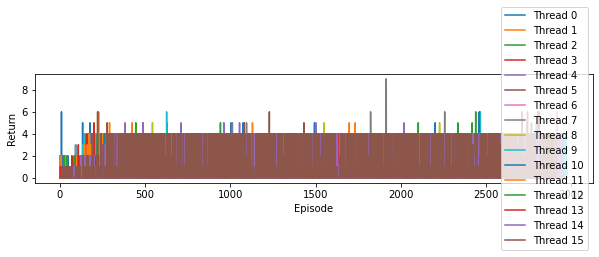

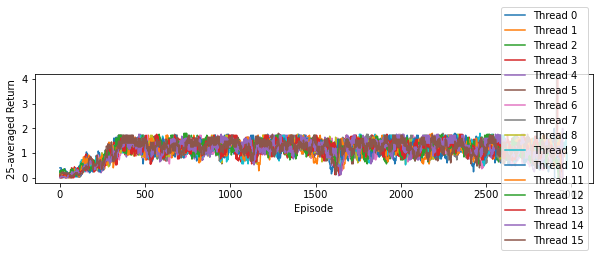

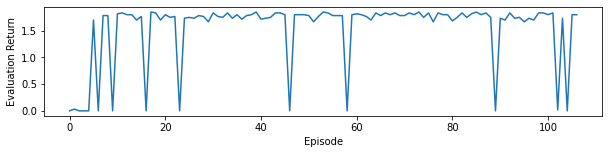

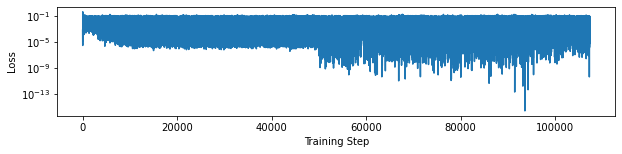

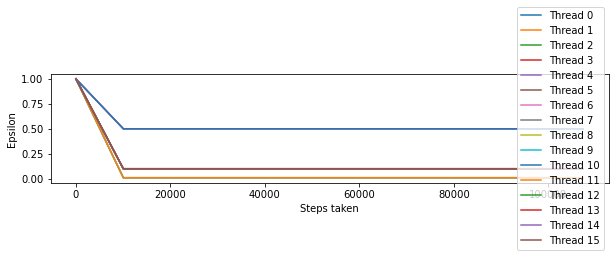

Running step  0  of  1000
Running step  10  of  1000
Running step  20  of  1000
Running step  30  of  1000
Running step  40  of  1000
Running step  50  of  1000
Running step  60  of  1000
Running step  70  of  1000
Running step  80  of  1000
Running step  90  of  1000
Running step  100  of  1000
Running step  110  of  1000
Running step  120  of  1000
Running step  130  of  1000
Running step  140  of  1000
Running step  150  of  1000
Running step  160  of  1000
Running step  170  of  1000
Running step  180  of  1000
Running step  190  of  1000
Running step  200  of  1000
Running step  210  of  1000
Running step  220  of  1000
Running step  230  of  1000
Running step  240  of  1000
Running step  250  of  1000
Running step  260  of  1000
Running step  270  of  1000
Running step  280  of  1000
Running step  290  of  1000
Running step  300  of  1000
Running step  310  of  1000
Running step  320  of  1000
Running step  330  of  1000
Running step  340  of  1000
Running step  350  of  1000
Run

In [ ]:
epochs=10000000
for i in range(epochs):
    agent.start_threads(1000)